In [4]:
import pandas as pd

df = pd.read_csv("covid19_tweets.csv")

print("Dataset shape:", df.shape)
df.head(3)

Dataset shape: (179108, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False


#### Filtering Tweeets That Mention "Pfizer"

In [6]:
# Filtering tweets containing the word "Pfizer"
pfizer_df = df[df["text"].str.contains("Pfizer", case = False, na = False)].copy()

# Resetting index
pfizer_df.reset_index(drop = True, inplace = True)

# Checking number of relevant tweets
print("Number of Pfizer-related tweets:", len(pfizer_df))
pfizer_df[["date", "text"]].head()

Number of Pfizer-related tweets: 73


,date,text
0,2020-07-25 08:59:59,"@pfizer, @BioNTech_Group Win $1.95B “Warp Spee..."
1,2020-07-25 08:59:43,2 doses for $20 each is a great deal! I would ...
2,2020-07-25 04:13:36,"WeekThatWas -- @pfizer, @BioNTech_Group Win $1..."
3,2020-07-25 04:12:16,WeekThatWas -- Experts discuss #COVID19 vaccin...
4,2020-07-25 01:55:02,Experts discuss #COVID19 vaccine candidates fr...


#### Cleaning the Tweet Text

In [8]:
import re

def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#|w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower().strip()
    return text

# Applying cleaning fucntion
pfizer_df["clean_text"] = pfizer_df["text"].apply(clean_tweet)

# Previewing cleaned tweets
pfizer_df[["text", "clean_text"]].head()

,text,clean_text
0,"@pfizer, @BioNTech_Group Win $1.95B “Warp Spee...",win b warp speed order for covid vaccine via
1,2 doses for $20 each is a great deal! I would ...,doses for each is a great deal i ould pay for...
2,"WeekThatWas -- @pfizer, @BioNTech_Group Win $1...",weekthatwas win b warp speed order for covi...
3,WeekThatWas -- Experts discuss #COVID19 vaccin...,weekthatwas experts discuss covid vaccine can...
4,Experts discuss #COVID19 vaccine candidates fr...,experts discuss covid vaccine candidates from ...


In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initializing VADER
analyzer = SentimentIntensityAnalyzer()

# Defining sentiment function
def get_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Applying to cleaned tweets
pfizer_df["sentiment"] = pfizer_df["clean_text"].apply(get_sentiment)

# Previewing results
pfizer_df[["clean_text", "sentiment"]].head()

,clean_text,sentiment
0,win b warp speed order for covid vaccine via,Positive
1,doses for each is a great deal i ould pay for...,Positive
2,weekthatwas win b warp speed order for covi...,Positive
3,weekthatwas experts discuss covid vaccine can...,Neutral
4,experts discuss covid vaccine candidates from ...,Neutral


#### Visualizing the Sentiment Results

##### 1. Pie Chart of Sentiment Distribution

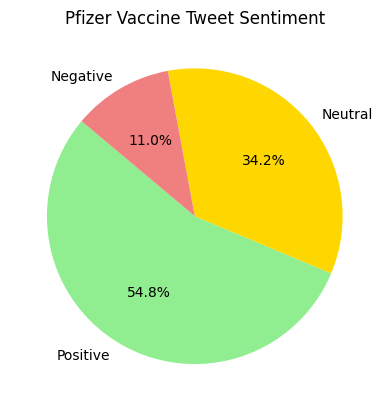

In [13]:
import matplotlib.pyplot as plt

# Counting sentiment labels
sentiment_counts = pfizer_df["sentiment"].value_counts()

# Plotting pie chart
colors = ["lightgreen", "gold", "lightcoral"]
sentiment_counts.plot.pie(autopct = "%1.1f%%", colors = colors, startangle = 140)
plt.title("Pfizer Vaccine Tweet Sentiment")
plt.ylabel("")
plt.show()

##### 2. Word Cloud of All Tweets

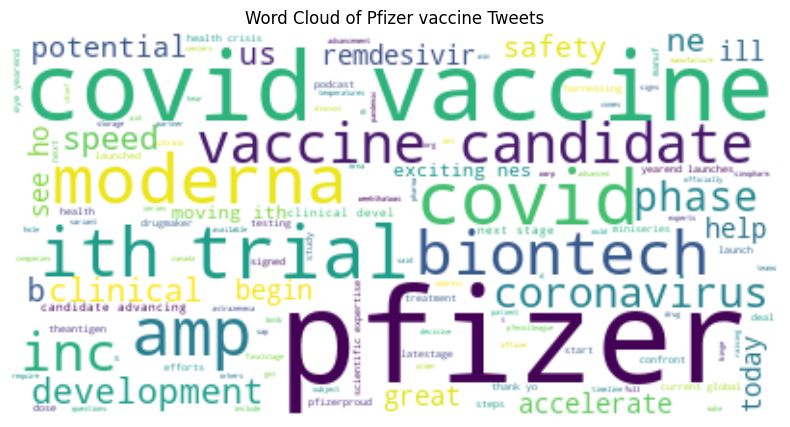

In [22]:
from wordcloud import WordCloud

# Combining all clean tweet texts into one string
all_words = " ".join(pfizer_df["clean_text"])

# Generate word cloud
wordcloud = WordCloud(width = 400, height = 200, background_color = "white").generate(all_words)

# Plotting word cloud
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud of Pfizer vaccine Tweets")
plt.show()

 ##### Word Clouds by Sentiment Class

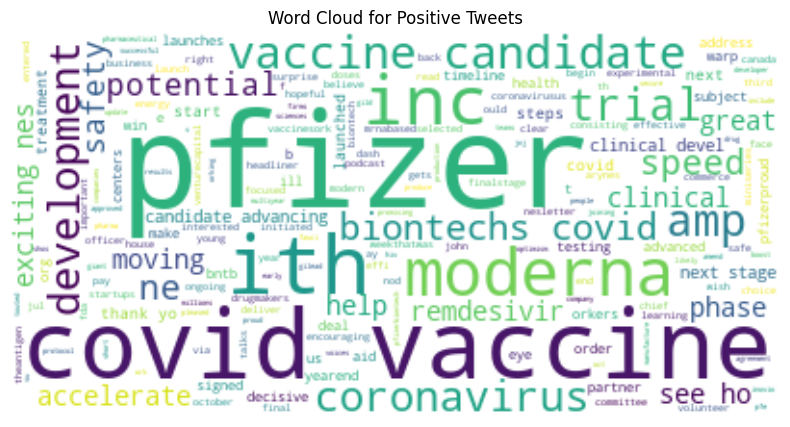

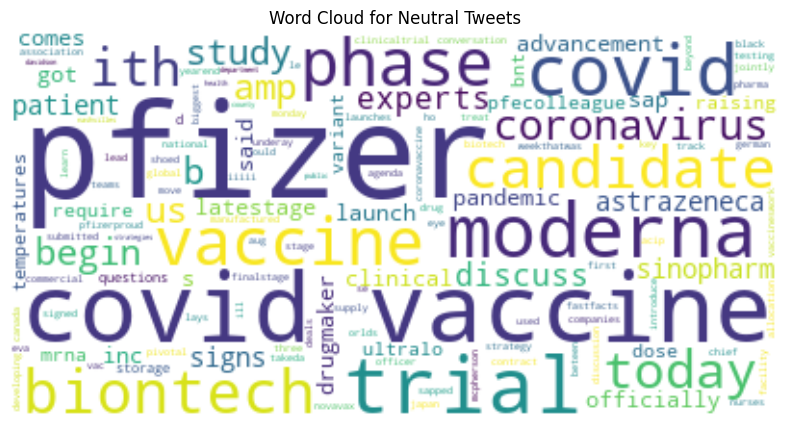

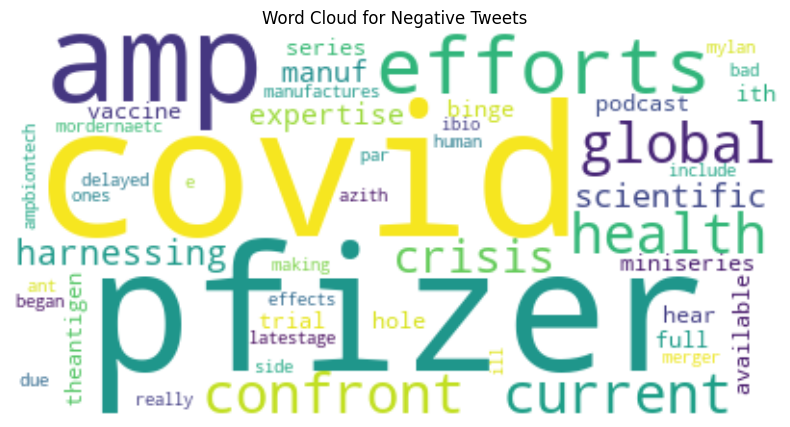

In [23]:
# Looping through each unique sentiment class
for label in pfizer_df["sentiment"].unique():

    # Filtering tweets by sentiment
    text = " ".join(pfizer_df[pfizer_df["sentiment"] == label]["clean_text"])

    # Generating word cloud
    wordcloud = WordCloud(width = 400, height = 200, background_color = "white").generate(text)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label} Tweets')
    plt.show()

#### Building a Basic ML Classifier Using the Labeled Data

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

##### Preparing the data

In [26]:
# Using cleaned text and sentiment
X = pfizer_df["clean_text"]
y = pfizer_df["sentiment"]

# Converting text to TF-IDF features
vectorizer = TfidfVectorizer(max_features = 1000, ngram_range = (1, 2))
X_vectorized = vectorizer.fit_transform(X)

# Splitting into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size = 0.2, random_state = 42)

##### Training Logistic Regression Model

In [32]:
# Initializing and training model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on test set
y_pred = model.predict(X_test)

# Evaluating
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification_report:\n")
print(classification_report(y_test, y_pred, zero_division = 0))

# Predicting a new tweet
sample = ["i don't trust pfizer at all"]
sample_vectorized = vectorizer.transform(sample)
print("Predicted Sentiment:", model.predict(sample_vectorized)[0])

Accuracy: 0.7333333333333333

Classification_report:

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
     Neutral       1.00      0.50      0.67         4
    Positive       0.69      1.00      0.82         9

    accuracy                           0.73        15
   macro avg       0.56      0.50      0.49        15
weighted avg       0.68      0.73      0.67        15

Predicted Sentiment: Neutral


#### SMOTE + Sentiment Classifier

##### Applying SMOTE and Retraining the Classifier

In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Resampling to balance the sentiment classes
smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

# Training the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting & evaluating
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.75

Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         6
     Neutral       0.58      0.88      0.70         8
    Positive       0.83      0.50      0.62        10

    accuracy                           0.75        24
   macro avg       0.81      0.79      0.78        24
weighted avg       0.79      0.75      0.74        24



In [34]:
import joblib
joblib.dump(model, "pfizer_sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Group texts by sentiment
sentiments = ['Positive', 'Neutral', 'Negative']

for sentiment in sentiments:
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Save to PNG
    filename = f'wordcloud_{sentiment.lower()}.png'
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment} Sentiment Word Cloud')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

KeyError: 'sentiment'